In [15]:
def rle_decode(mask_rle, shape=(520, 704, 1), color=1):  # function to convert tabular mask data to image
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height, width, channels) of array to return 
    color: color for the mask
    Returns numpy array (mask)

    '''
    s = mask_rle.split()
    
    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]
    
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
            
    for start, end in zip(starts, ends):
        img[start : end] = color
    
    return img.reshape(shape)  # Gives a new shape to an array without changing its data

## Vec2Instance 
### Centroid model training


In [54]:
#Loading libs 
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, GaussianNoise, Lambda, Dropout, UpSampling2D
from keras import backend as K
from keras.optimizer_v2 import adam
from keras.metrics import RootMeanSquaredError
from sklearn.model_selection import train_test_split


In [32]:
#Loading in the data 

#training meta data 
df_train = pd.read_csv(R"data/train/.csv")
x_train = np.stack([cv2.imread(f"data/train/{image_id}.png")for image_id in df_train["id"].unique()])


In [7]:
x_train.shape # (samples,height,wdith, RGB)

(606, 520, 704, 3)

In [20]:

  # (colors=False)
  
  
def create_centroids(annotations : pd.Series):
    
    mask = np.zeros((520, 704, 1))  # Return a new array of given shape and type, filled with zeros. Set the size and color scheme in one color
    for label in annotations:  # we go through all the data by masks (in the column "annotation")
        decoded = rle_decode(label, shape=(520, 704, 1))
        nonzero = decoded.nonzero()
        centroid = (round(nonzero[0].mean()), round(nonzero[1].mean())) # calculating centroid for each annotation
        mask[centroid] = 1
    return mask
        

In [22]:
y_train = df_train.groupby("id")["annotation"].apply(create_centroids)


In [29]:
y_train = np.stack(y_train)
y_train.shape

(606, 520, 704, 1)

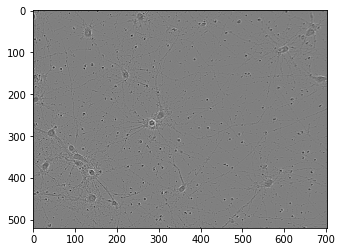

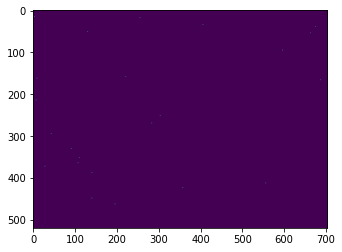

In [33]:
'''plot sample of training data'''

rand_idx = np.random.randint(0,y_train.shape[0]) # generation random index to choose random sample

plt.imshow(x_train[rand_idx,:,:,:])
plt.show()

plt.imshow(y_train[rand_idx,:,:,0])
plt.show()

### 2) Designing the Neural Network

It's a typical CNN with Convolutional layers, Max pooling operations and Dropouts.

In [55]:
x_in = Input(shape=(520, 704, 3)) # input shape: (height, width, 3 bands of RGB)

x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_temp)
x_temp = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions
x_temp = MaxPooling2D((2,2))(x_temp)
x_temp = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions
x_temp = MaxPooling2D((2,2))(x_temp)
x_temp = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions

x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_out = Conv2D(1, (1, 1), activation='relu', padding='same')(x_temp)
x_out = UpSampling2D(8)(x_out)

# custom loss function to calculation weighted RMSE
def customLoss(yTrue, yPred):
    return K.sqrt(K.sum(K.flatten( K.tf.multiply(K.square(yTrue - yPred), yTrue+1)/(1*2+1) ))/(32*32))

model = Model(inputs=x_in, outputs=x_out)

model.compile(loss=customLoss, optimizer=adam.Adam()) # setting loss and optimizer

model.summary() # printing the model summary

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 520, 704, 3)]     0         
                                                                 
 conv2d_88 (Conv2D)          (None, 520, 704, 32)      896       
                                                                 
 dropout_32 (Dropout)        (None, 520, 704, 32)      0         
                                                                 
 conv2d_89 (Conv2D)          (None, 520, 704, 32)      9248      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 260, 352, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_90 (Conv2D)          (None, 260, 352, 32)      9248      
                                                           

In [43]:
x_train,  x_val,y_train, y_val = train_test_split(x_train,y_train,test_size=0.2)

In [57]:
'''training the model'''


batch_size = 50
epochs = 3

fit_h = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=1, validation_data=(x_val,y_val))

Epoch 1/3
 5/10 [==============>...............] - ETA: 2:01 - loss: 49.8769

KeyboardInterrupt: 